In [1]:
#!pip install tensorflow==1.14.0

In [2]:
#!pip install keras==2.2.5

In [3]:
import os
os.environ["PYTHONHASHSEED"] = "13"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(13)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(13)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(13)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [4]:
import gc
import warnings

import lightgbm as lgb
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from tqdm.notebook import tqdm

import keras
from keras.models import Sequential
from keras.layers import BatchNormalization, Dense, Dropout

path_data = "../input/ashrae-energy-prediction/"
path_train = path_data + "train.csv"
path_test = path_data + "test.csv"
path_building = path_data + "building_metadata.csv"
path_weather_train = path_data + "weather_train.csv"
path_weather_test = path_data + "weather_test.csv"

myfavouritenumber = 13
seed = myfavouritenumber

warnings.filterwarnings("ignore")

In [5]:
site_id = 6

In [6]:
df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)

building = pd.read_csv(path_building)

weather_train = pd.read_csv(path_weather_train)
weather_test = pd.read_csv(path_weather_test)

weather_train.drop(["sea_level_pressure", "wind_direction", "wind_speed"], axis=1, inplace=True)
weather_test.drop(["sea_level_pressure", "wind_direction", "wind_speed"], axis=1, inplace=True)

weather_train = weather_train.groupby("site_id").apply(lambda group: group.interpolate(limit_direction="both"))
weather_test = weather_test.groupby("site_id").apply(lambda group: group.interpolate(limit_direction="both"))

df_train = df_train.merge(building, on="building_id")
df_test = df_test.merge(building, on="building_id")

df_train = df_train[df_train.site_id == site_id]
df_test = df_test[df_test.site_id == site_id]

df_train = df_train[~((df_train.meter_reading == 0) & (df_train.meter == 0))]
df_train = df_train[~((df_train.building_id == 761) & (df_train.timestamp < "2016-09-02"))]

df_train = df_train[df_train.meter == 0]

df_train = df_train.merge(weather_train, on=["site_id", "timestamp"], how="left")
df_test = df_test.merge(weather_test, on=["site_id", "timestamp"], how="left")

df_train.timestamp = pd.to_datetime(df_train.timestamp, format='%Y-%m-%d %H:%M:%S')
df_test.timestamp = pd.to_datetime(df_test.timestamp, format='%Y-%m-%d %H:%M:%S')

df_train.building_id = df_train.building_id.astype("str")
df_test.building_id = df_test.building_id.astype("str")

df_train["log_meter_reading"] = np.log1p(df_train.meter_reading)

del building
gc.collect()

0

In [7]:
df_train["hour"] = df_train.timestamp.dt.hour.astype("str")
df_test["hour"] = df_test.timestamp.dt.hour.astype("str")

df_train["weekday"] = df_train.timestamp.dt.weekday.astype("str")
df_test["weekday"] = df_test.timestamp.dt.weekday.astype("str")

df_train["month"] = df_train.timestamp.dt.month.astype("str")
df_test["month"] = df_test.timestamp.dt.month.astype("str")

In [8]:
features = [
    "building_id",
    "square_feet",
    "year_built",
    "floor_count",
    "primary_use",
    "air_temperature",
    "cloud_coverage",
    "dew_temperature",
    "precip_depth_1_hr",
    "hour",
    "weekday",
    "month"
]

In [9]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [10]:
cv = 4
folds = KFold(n_splits = cv, shuffle = False, random_state = seed)

df_cv = []
df_preds = []

Building Model for site_id 6 and meter 0
Preparing Site: 6 , meter: 0 , Fold: 1




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 232137 samples, validate on 77380 samples
Epoch 1/31
 - 1s - loss: 4.6682 - val_loss: 3.0932
Epoch 2/31
 - 1s - loss: 3.8040 - val_loss: 1.9247
Epoch 3/31
 - 1s - loss: 2.5767 - val_loss: 0.6786
Epoch 4/31
 - 1s - loss: 1.7230 - val_loss: 0.9044
Epoch 5/31
 - 1s - loss: 1.6222 - val_loss: 1.0830
Epoch 6/31
 - 1s - loss: 1.6060 - val_loss: 1.1225
Epoch 7/31
 - 1s - loss: 1.5909 - val_loss: 1.1346
Epoch 8/31
 - 1s - loss: 1.5734 - val_loss: 1.1396
Epoch 9/31
 - 1s - loss: 1.5392 - val_loss: 1.1451
Epoch 10/31
 - 1s - loss: 1.5169 - val_loss: 1.1474
Epoch 11/31
 - 1s - loss: 1.4892 - val_loss: 1.1516
Epoch 12/31
 - 1s - loss: 1.4685 - val_loss: 1.1565
Epoch 13/31
 - 1s - loss: 1.4429 - val_

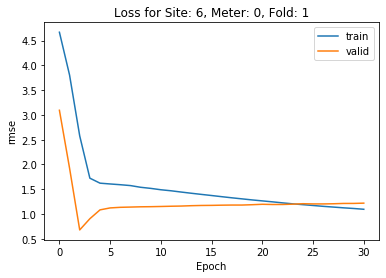

Preparing Site: 6 , meter: 0 , Fold: 2
Train on 232138 samples, validate on 77379 samples
Epoch 1/31
 - 2s - loss: 4.4321 - val_loss: 3.6530
Epoch 2/31
 - 1s - loss: 3.5295 - val_loss: 2.5335
Epoch 3/31
 - 1s - loss: 2.3471 - val_loss: 1.2045
Epoch 4/31
 - 1s - loss: 1.6700 - val_loss: 0.8141
Epoch 5/31
 - 1s - loss: 1.6250 - val_loss: 0.8003
Epoch 6/31
 - 1s - loss: 1.6194 - val_loss: 0.7998
Epoch 7/31
 - 1s - loss: 1.6058 - val_loss: 0.7979
Epoch 8/31
 - 1s - loss: 1.5848 - val_loss: 0.7922
Epoch 9/31
 - 1s - loss: 1.5605 - val_loss: 0.7843
Epoch 10/31
 - 1s - loss: 1.5420 - val_loss: 0.7762
Epoch 11/31
 - 1s - loss: 1.5244 - val_loss: 0.7702
Epoch 12/31
 - 1s - loss: 1.5017 - val_loss: 0.7652
Epoch 13/31
 - 1s - loss: 1.4814 - val_loss: 0.7603
Epoch 14/31
 - 1s - loss: 1.4627 - val_loss: 0.7556
Epoch 15/31
 - 1s - loss: 1.4412 - val_loss: 0.7541
Epoch 16/31
 - 1s - loss: 1.4233 - val_loss: 0.7509
Epoch 17/31
 - 1s - loss: 1.4067 - val_loss: 0.7475
Epoch 18/31
 - 1s - loss: 1.3872 - 

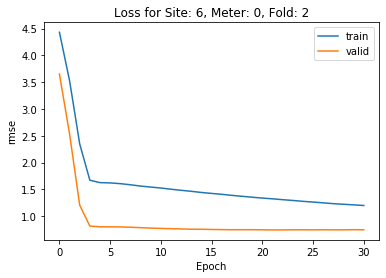

Preparing Site: 6 , meter: 0 , Fold: 3
Train on 232138 samples, validate on 77379 samples
Epoch 1/31
 - 2s - loss: 4.4458 - val_loss: 3.9859
Epoch 2/31
 - 1s - loss: 3.4365 - val_loss: 2.7205
Epoch 3/31
 - 1s - loss: 2.3740 - val_loss: 1.3207
Epoch 4/31
 - 1s - loss: 1.7704 - val_loss: 0.6296
Epoch 5/31
 - 1s - loss: 1.6704 - val_loss: 0.5615
Epoch 6/31
 - 1s - loss: 1.6538 - val_loss: 0.5620
Epoch 7/31
 - 1s - loss: 1.6349 - val_loss: 0.5642
Epoch 8/31
 - 1s - loss: 1.6118 - val_loss: 0.5658
Epoch 9/31
 - 1s - loss: 1.6000 - val_loss: 0.5666
Epoch 10/31
 - 1s - loss: 1.5794 - val_loss: 0.5667
Epoch 11/31
 - 1s - loss: 1.5643 - val_loss: 0.5669
Epoch 12/31
 - 1s - loss: 1.5467 - val_loss: 0.5667
Epoch 13/31
 - 1s - loss: 1.5248 - val_loss: 0.5658
Epoch 14/31
 - 1s - loss: 1.5102 - val_loss: 0.5636
Epoch 15/31
 - 1s - loss: 1.4913 - val_loss: 0.5585
Epoch 16/31
 - 1s - loss: 1.4801 - val_loss: 0.5472
Epoch 17/31
 - 1s - loss: 1.4594 - val_loss: 0.5371
Epoch 18/31
 - 1s - loss: 1.4401 - 

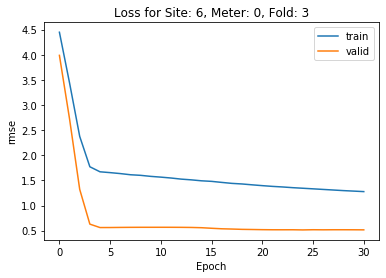

Preparing Site: 6 , meter: 0 , Fold: 4
Train on 232138 samples, validate on 77379 samples
Epoch 1/31
 - 2s - loss: 4.0321 - val_loss: 5.3815
Epoch 2/31
 - 1s - loss: 3.2911 - val_loss: 4.3205
Epoch 3/31
 - 1s - loss: 2.2107 - val_loss: 2.9194
Epoch 4/31
 - 1s - loss: 1.4625 - val_loss: 2.0727
Epoch 5/31
 - 1s - loss: 1.3643 - val_loss: 1.9010
Epoch 6/31
 - 1s - loss: 1.3436 - val_loss: 1.8674
Epoch 7/31
 - 1s - loss: 1.3231 - val_loss: 1.8541
Epoch 8/31
 - 1s - loss: 1.2989 - val_loss: 1.8402
Epoch 9/31
 - 1s - loss: 1.2761 - val_loss: 1.8356
Epoch 10/31
 - 1s - loss: 1.2521 - val_loss: 1.8303
Epoch 11/31
 - 1s - loss: 1.2272 - val_loss: 1.8230
Epoch 12/31
 - 1s - loss: 1.2064 - val_loss: 1.8138
Epoch 13/31
 - 1s - loss: 1.1816 - val_loss: 1.8018
Epoch 14/31
 - 1s - loss: 1.1601 - val_loss: 1.7907
Epoch 15/31
 - 1s - loss: 1.1380 - val_loss: 1.7746
Epoch 16/31
 - 1s - loss: 1.1155 - val_loss: 1.7607
Epoch 17/31
 - 1s - loss: 1.0937 - val_loss: 1.7410
Epoch 18/31
 - 1s - loss: 1.0709 - 

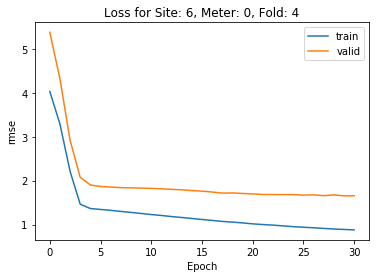


CV RMSE for Site: 6 and Meter: 0 is 1.2508097839111834

CV RMSE for Site: 6 is 1.2508097839111834


In [11]:
for meter in df_train.meter.unique():
    print("Building Model for site_id", site_id, "and meter", meter)
        
    df_train_site_meter = df_train[df_train.meter == meter].reset_index(drop=True)
    df_test_site_meter = df_test[df_test.meter == meter].reset_index(drop=True)
    
    pred_val = np.zeros(df_train_site_meter.shape[0])
    pred_test = np.zeros(df_test_site_meter.shape[0])

    row_ids_test = df_test_site_meter.row_id
    y_train_site_meter = df_train_site_meter.log_meter_reading.values
    
    df_train_site_meter = df_train_site_meter[features]
    df_test_site_meter = df_test_site_meter[features]

    df_train_site_meter = pd.get_dummies(df_train_site_meter)
    df_test_site_meter = pd.get_dummies(df_test_site_meter)
        
    for k, (train_idx, valid_idx) in enumerate(folds.split(df_train_site_meter, y_train_site_meter)):
        print("Preparing Site:", site_id, ", meter:", meter, ", Fold:", k+1)
        
        X_train, y_train = df_train_site_meter.iloc[train_idx], y_train_site_meter[train_idx]
        X_valid, y_valid = df_train_site_meter.iloc[valid_idx], y_train_site_meter[valid_idx]
        
        X_train.dropna(axis=1, how="all", inplace=True)
        X_train = X_train.loc[:, (X_train != X_train.iloc[0]).any()]

        X_valid = X_valid[X_train.columns]
        X_test = df_test_site_meter[X_train.columns]
        
        df_means = pd.concat([X_train, X_valid, X_test], ignore_index=True).mean()
        X_train.fillna(df_means, inplace=True)
        X_valid.fillna(df_means, inplace=True)
        X_test.fillna(df_means, inplace=True)
        
        sc = MinMaxScaler()
        sc.fit(pd.concat([X_train, X_valid, X_test], ignore_index=True))
        
        X_train = np.array(sc.transform(X_train))
        X_valid = np.array(sc.transform(X_valid))
        X_test = np.array(sc.transform(X_test))
        
        model = Sequential()
        model.add(Dense(16, input_dim=X_train.shape[1], activation="relu", kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(4, activation="tanh", kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(2, activation="tanh", kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(loss=rmse, optimizer="adam")
        
        model_ffnn = model.fit(X_train, y_train, epochs=31, batch_size=1000, validation_data=(X_valid, y_valid), verbose=2, shuffle=False)

        plt.plot(model_ffnn.history["loss"])
        plt.plot(model_ffnn.history["val_loss"])
        plt.title("Loss for Site: " + str(site_id) + ", Meter: " + str(meter) + ", Fold: " + str(k+1))
        plt.ylabel("rmse")
        plt.xlabel("Epoch")
        plt.legend(["train", "valid"], loc="upper right")
        plt.show()
        
        pred_val[valid_idx] = model.predict(X_valid).ravel()
        pred_test += model.predict(X_test).ravel() / cv
        
        gc.collect()
        
    df_valid = pd.DataFrame({"site_id": site_id, "meter": meter, "meter_reading": np.expm1(y_train_site_meter), "pred_ffnn": np.clip(np.expm1(pred_val), 0, a_max=None)})
    df_pred = pd.DataFrame({"row_id": row_ids_test, "meter_reading": np.clip(np.expm1(pred_test), 0, a_max=None)})
    
    df_cv.append(df_valid)
    df_preds.append(df_pred)
    
    gc.collect()
    
    print("\nCV RMSE for Site:", site_id, "and Meter:", meter, "is", np.sqrt(mean_squared_error(np.log1p(df_valid.meter_reading), np.log1p(df_valid.pred_ffnn))))

df_cv = pd.concat(df_cv)
print("\nCV RMSE for Site:", site_id, "is", np.sqrt(mean_squared_error(np.log1p(df_cv.meter_reading), np.log1p(df_cv.pred_ffnn))))


In [14]:
#f_preds = pd.concat(df_preds)
df_preds.to_csv("../sub/ffnn_pred_site_" + str(site_id) + ".csv", index=False)